In [2]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.optimize import curve_fit
import plotly.io as pio
import os
import re

# --- Custom Plotly Template with axis label & tick label font sizes ---
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
        # 'titlefont': dict(size=34),   # axis label font size
        # 'tickfont': dict(size=30),   # tick labels font size
    },
    'yaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
        # 'titlefont': dict(size=34),   # axis label font size
        # 'tickfont': dict(size=30),    # tick labels font size
    },
    'font': {
        'family': 'mathjax',
        'size': 30,  # legend, annotation, general text
    }
}

### percentage change

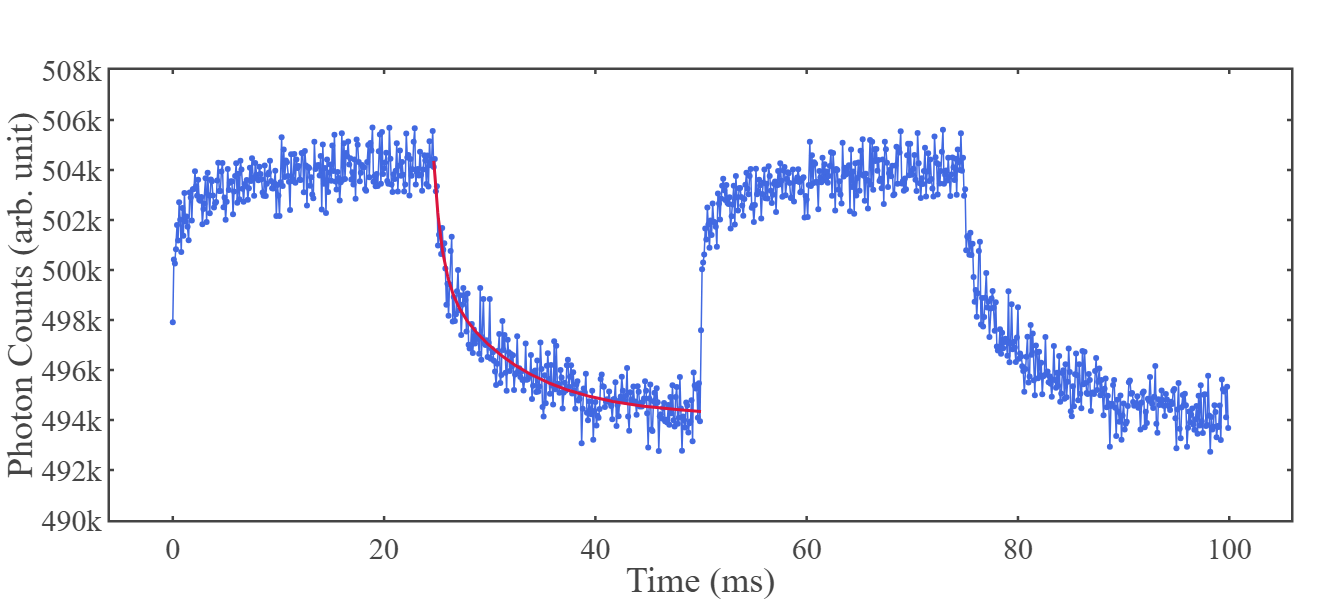

In [15]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import os
import re
from scipy.interpolate import interp1d

# ============================================================
# --- Custom Plotly Template ---
# ============================================================
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
    },
    'yaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
    },
    'font': {
        'family': 'mathjax',
        'size': 30,
    }
}

# ============================================================
# --- Calibration Tables ---
# ============================================================
calib_975 = {
    10: 1.79, 30: 5.4, 50: 10, 70: 16.87, 90: 22,
    110: 25.4, 130: 29.72, 150: 31.21, 170: 36.48,
    190: 43, 210: 52.5, 230: 53.62, 250: 60.57
}

calib_1064 = {
    1.75: 4.6, 2: 7.6, 2.25: 10.25, 2.5: 14.3, 2.75: 21,
    3: 36.65, 3.25: 43.6, 3.5: 53, 3.75: 67, 3.86: 77
}

interp_975 = interp1d(list(calib_975.keys()), list(calib_975.values()), fill_value="extrapolate")
interp_1064 = interp1d(list(calib_1064.keys()), list(calib_1064.values()), fill_value="extrapolate")

# ============================================================
# --- Paths and Parameters ---
# ============================================================
base_path = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\2nd Oct NaBiF4\Percentage Modulation"
save_folder = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper"
os.makedirs(save_folder, exist_ok=True)

pattern = re.compile(r"1064nm_(\d*\.?\d+)mW.*975nm_(\d+)mW\.txt")

# ============================================================
# --- Focus on highest 1064 nm folder ---
# ============================================================
target_folder = "1064nm_3.86mA"
folder_path = os.path.join(base_path, target_folder)

if not os.path.exists(folder_path):
    raise FileNotFoundError(f"Target folder not found: {folder_path}")

datasets = []

for file in os.listdir(folder_path):
    if file.endswith(".txt"):
        match = pattern.match(file)
        if match:
            i_1064 = float(match.group(1))
            p_975_raw = int(match.group(2))

            p_1064_sample = float(interp_1064(i_1064))
            p_975_sample = float(interp_975(p_975_raw))

            file_path = os.path.join(folder_path, file)
            arr = np.loadtxt(file_path, skiprows=1)
            datasets.append((p_975_sample, arr, p_1064_sample))

# ============================================================
# --- Select lowest 975 nm power dataset ---
# ============================================================
if not datasets:
    raise RuntimeError("No valid datasets found.")

datasets.sort(key=lambda x: x[0])  # sort by 975 nm power
lowest_975_dataset = datasets[0]   # pick the lowest power dataset

p_975_sample, arr, p_1064_sample = lowest_975_dataset

# ============================================================
# --- Plot Raw Data (hide legend) ---
# ============================================================
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=arr[:, 0]/1e9,       # convert to ms for plotting (consistent with your previous code)
    y=arr[:, 1],
    mode='lines+markers',
    # no name -> no legend entry, also enforce showlegend=False
    showlegend=False,
    line=dict(width=1.5, color='royalblue'),
))

# ============================================================
# --- Add Corrected Double Exponential Fit Curve (no normalization) ---
# ============================================================

# Fit parameters and constants (as provided)
y0 = 4.9415e+5
A1 = 4485.3
tau1 = 7.5842e+8
A2 = 5729.9
tau2 = 7.4681e+9
X0 = 2.47e+10  # constant

# Fit x-range in ms (user provided) and convert back to the original units used by taus/X0
x1_ms, x2_ms = 24.7, 50
# original units = ms * 1e9 (this matches how arr[:,0] was used in your earlier code)
x_fit_orig = np.linspace(x1_ms, x2_ms, 400) * 1e9  # same units as tau1,tau2,X0

# Double exponential model including y0
y_fit = y0 + A1 * np.exp(-(x_fit_orig - X0) / tau1) + A2 * np.exp(-(x_fit_orig - X0) / tau2)

# plot fit (convert x back to ms for plotting)
fig.add_trace(go.Scatter(
    x=x_fit_orig / 1e9,   # back to ms
    y=y_fit,
    mode='lines',
    line=dict(width=3, color='crimson'),
    showlegend=False
))

# ============================================================
# --- Figure Layout (set y-range max to 506000) ---
# ============================================================
fig.update_layout(
    template=fig_template,
    xaxis_title="Time (ms)",
    yaxis_title="Photon Counts (arb. unit)",
    width=800,
    height=600,
    margin=dict(l=110, r=50, t=70, b=80),
)

# set explicit y-axis range (0 to 506000)
fig.update_yaxes(range=[490000, 508000])

fig.show()

# ============================================================
# --- Save Figure (using preferred format) ---
# ============================================================

output_path = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\per_modulation.png"

# pio.write_image(fig, output_path, format='png', scale=4)
# print(f"✅ Figure saved as: {output_path}")


Calibrated 975nm power: 0.32
Calibrated 1064nm power: 75.52


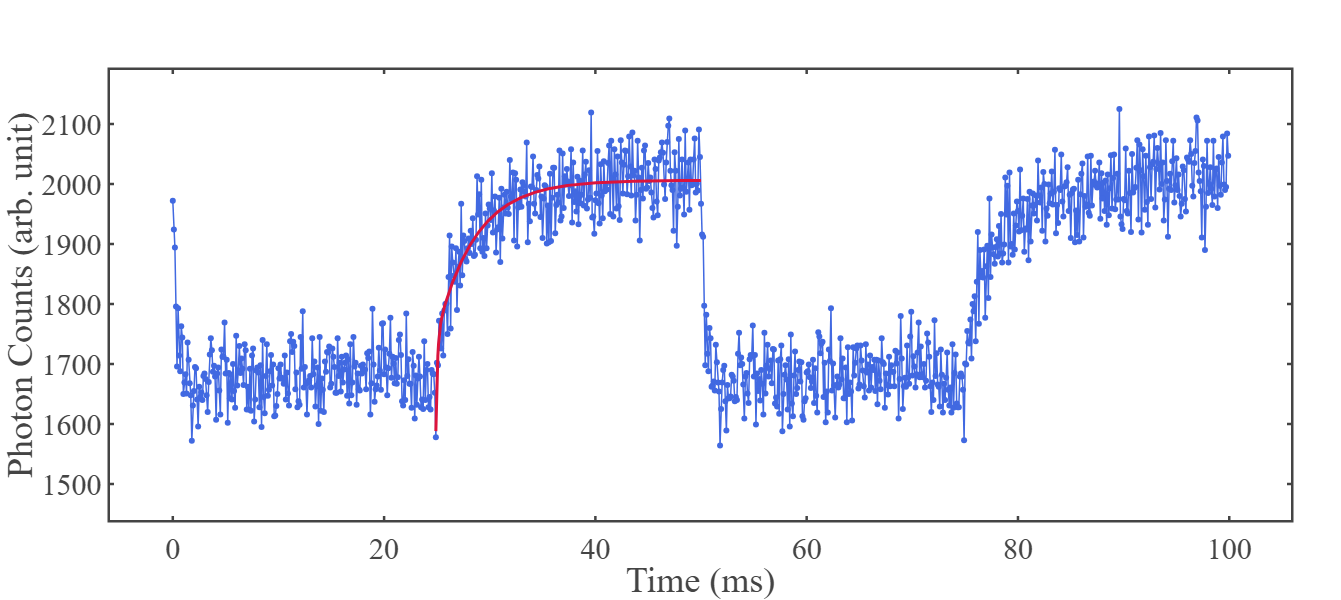

✅ Figure saved as: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\per_modulation_low_power.png


In [39]:
import numpy as np
import plotly.graph_objects as go
import plotly.io as pio
from scipy.optimize import curve_fit
import os

# ============================================================
# --- Custom Plotly Template ---
# ============================================================
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
    },
    'yaxis': {
        'ticks': 'inside',
        'mirror': 'ticks',
        'linewidth': 2.5,
        'tickwidth': 2.5,
        'ticklen': 4,
        'showline': True,
        'showgrid': False,
        'zerolinecolor': 'white',
    },
    'font': {
        'family': 'mathjax',
        'size': 30,
    }
}

# ============================================================
# --- Calibration Tables (for power-law extrapolation) ---
# ============================================================
calib_975 = {
    10: 1.79, 30: 5.4, 50: 10, 70: 16.87, 90: 22,
    110: 25.4, 130: 29.72, 150: 31.21, 170: 36.48,
    190: 43, 210: 52.5, 230: 53.62, 250: 60.57
}

calib_1064 = {
    1.75: 4.6, 2: 7.6, 2.25: 10.25, 2.5: 14.3, 2.75: 21,
    3: 36.65, 3.25: 43.6, 3.5: 53, 3.75: 67, 3.86: 77
}

def power_law(x, a, b):
    return a * np.power(x, b)

# Fit power-law curves
x_975 = np.array(list(calib_975.keys()))
y_975 = np.array(list(calib_975.values()))
params_975, _ = curve_fit(power_law, x_975, y_975, maxfev=5000)

x_1064 = np.array(list(calib_1064.keys()))
y_1064 = np.array(list(calib_1064.values()))
params_1064, _ = curve_fit(power_law, x_1064, y_1064, maxfev=5000)

def extrap_975(x): return power_law(x, *params_975)
def extrap_1064(x): return power_law(x, *params_1064)

# ============================================================
# --- File Path ---
# ============================================================
file_path = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\7th Oct NaBiF4\face on\good datas\1064nm_3.85mA\975nm_2mW.txt"

# Load data
arr = np.loadtxt(file_path, skiprows=1)

# ============================================================
# --- Optional: calibrated powers ---
# ============================================================
p_975_raw = 2      # from filename
i_1064 = 3.85      # from filename

p_975_sample = extrap_975(p_975_raw)
p_1064_sample = extrap_1064(i_1064)

print(f"Calibrated 975nm power: {p_975_sample:.2f}")
print(f"Calibrated 1064nm power: {p_1064_sample:.2f}")

# ============================================================
# --- Plot Raw Data ---
# ============================================================
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=arr[:, 0]/1e9,       # ns → ms
    y=arr[:, 1],
    mode='lines+markers',
    showlegend=False,
    line=dict(width=1.5, color='royalblue'),
))

# ============================================================
# --- Add Double Exponential Fit ---
# ============================================================
y0 = 2006.2
A1 = -155.76
tau1 = 1.4865e+8
A2 = -262.31
tau2 = 3.6513e+9
X0 = 2.49e+10

x1_ms, x2_ms = 24.9, 50
x_fit_orig = np.linspace(x1_ms, x2_ms, 400) * 1e9
y_fit = y0 + A1*np.exp(-(x_fit_orig - X0)/tau1) + A2*np.exp(-(x_fit_orig - X0)/tau2)

fig.add_trace(go.Scatter(
    x=x_fit_orig / 1e9,
    y=y_fit,
    mode='lines',
    line=dict(width=3, color='crimson'),
    showlegend=False
))

# ============================================================
# --- Layout ---
# ============================================================
fig.update_layout(
    template=fig_template,
    xaxis_title="Time (ms)",
    yaxis_title="Photon Counts (arb. unit)",
    width=800,
    height=600,
    margin=dict(l=110, r=50, t=70, b=80),
)

fig.update_yaxes(range=[1440, 2190])

fig.show()

# ============================================================
# --- Save Figure ---
# ============================================================
save_folder = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper"
os.makedirs(save_folder, exist_ok=True)
output_path = os.path.join(save_folder, "per_modulation_low_power.png")
pio.write_image(fig, output_path, format='png', scale=4)
print(f"✅ Figure saved as: {output_path}")


### Heatmap for high 975nm powers  

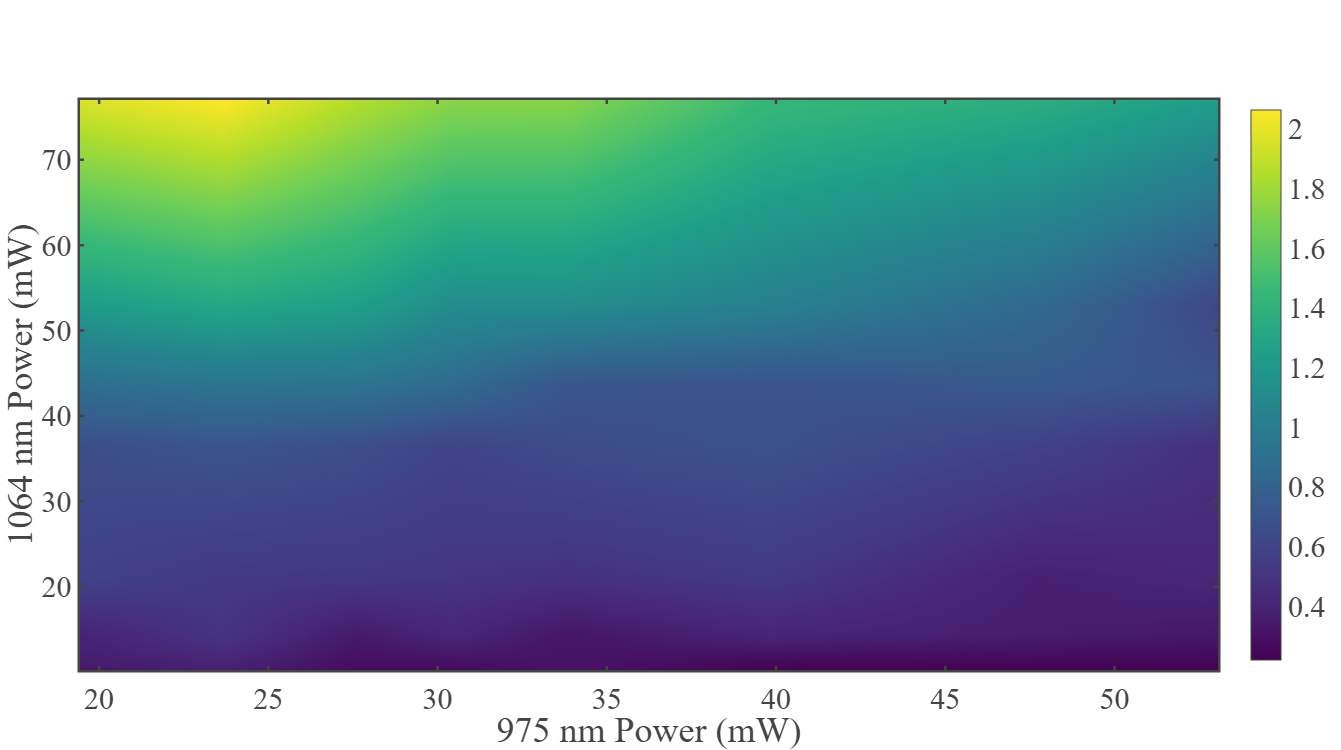

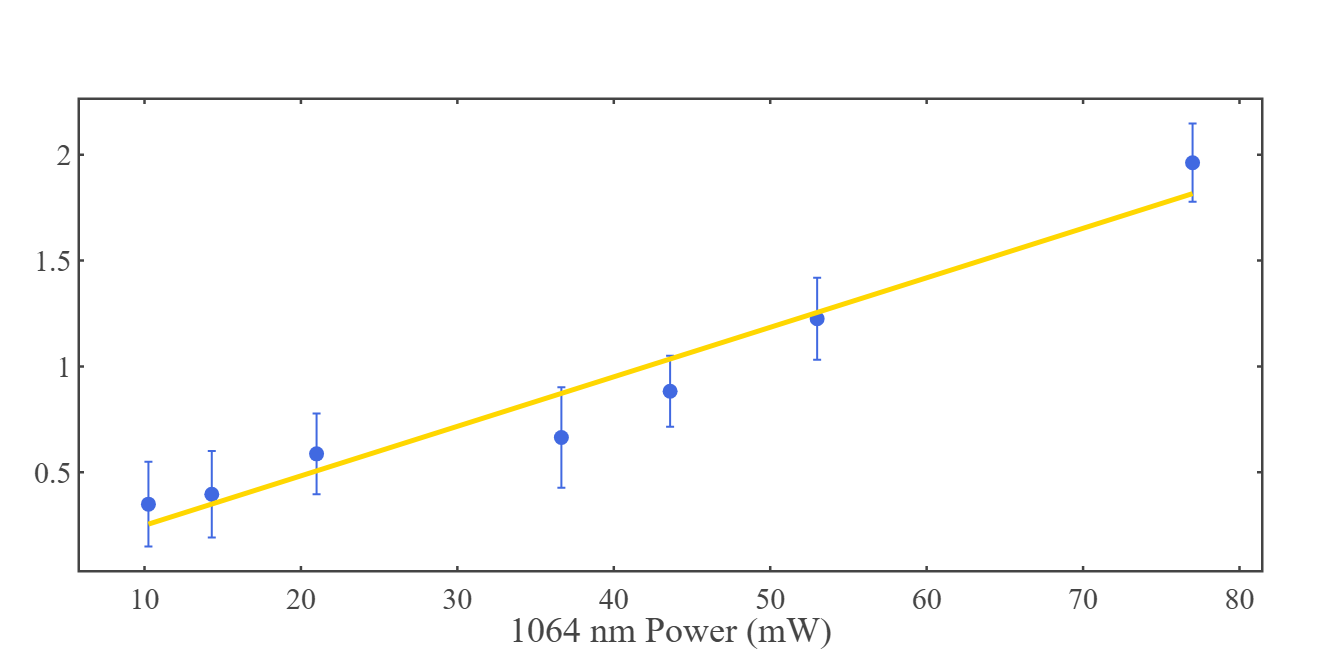

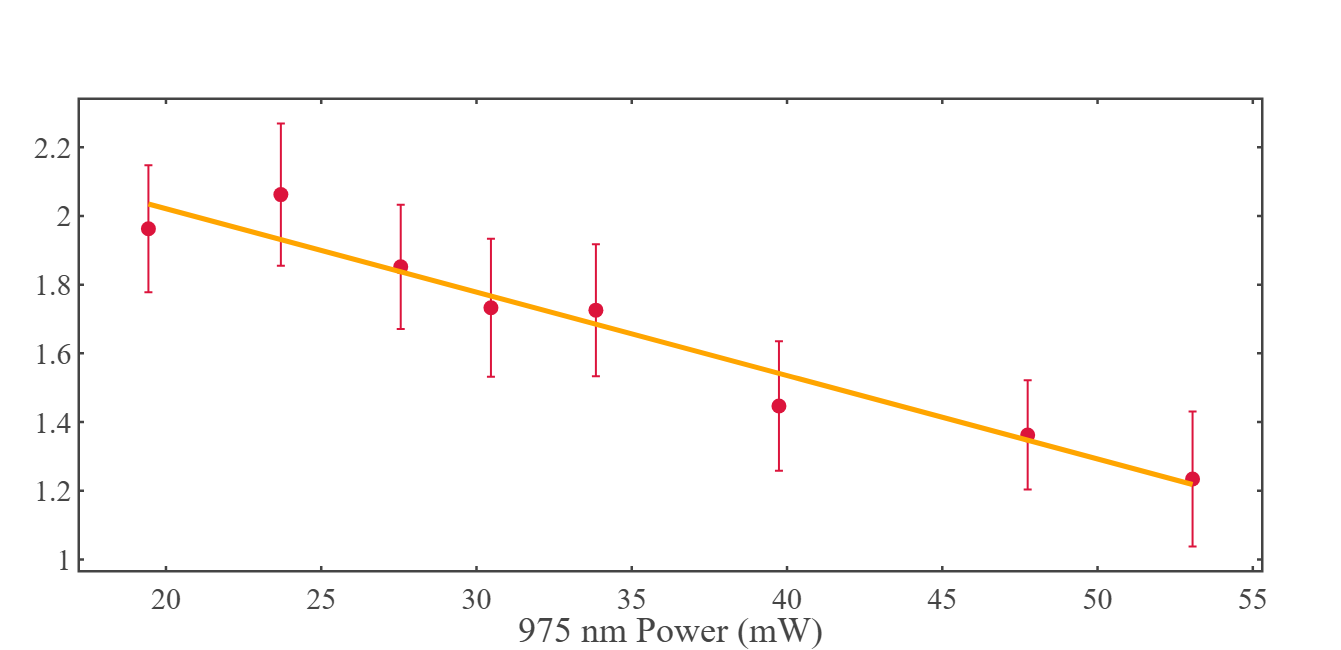

=== FIG1: Signal vs 1064 nm (lowest 975 nm = 19.44 mW) ===
 Linear Fit: Signal = m*P1064 + c
  Slope (sensitivity) m = 2.339180e-02 %/mW ± 2.419433e-03
  Intercept c = 1.532225e-02 % ± 1.064204e-01

=== FIG2: Signal vs 975 nm (highest 1064 nm = 77.00 mW) ===
 Linear Fit: Signal = m*P975 + c
  Slope (sensitivity) m = -2.429167e-02 %/mW ± 2.324763e-03
  Intercept c = 2.506936e+00 % ± 8.547331e-02

=== Data Statistics ===
Signal range: 0.22% to 2.06%
1064 nm power range: 10.25 mW to 77.00 mW
975 nm power range: 19.44 mW to 53.06 mW


In [44]:
import numpy as np
import pandas as pd
import os
import re
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import plotly.io as pio

# ============================================================
# --- Calibration Tables ---
# ============================================================
calib_975 = {10:1.79,30:5.4,50:10,70:16.87,90:22,110:25.4,130:29.72,150:31.21,170:36.48,190:43,210:52.5,230:53.62,250:60.57}
calib_1064 = {1.75:4.6,2:7.6,2.25:10.25,2.5:14.3,2.75:21,3:36.65,3.25:43.6,3.5:53,3.75:67,3.86:77}

interp_975 = interp1d(list(calib_975.keys()), list(calib_975.values()), fill_value="extrapolate")
interp_1064 = interp1d(list(calib_1064.keys()), list(calib_1064.values()), fill_value="extrapolate")

# ============================================================
# --- Figure Template ---
# ============================================================
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False,'zerolinecolor':'white'},
    'yaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False,'zerolinecolor':'white'},
    'font': {'family':'mathjax','size':30}
}

# ============================================================
# --- Parameters ---
# ============================================================
base_path = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\2nd Oct NaBiF4\Percentage Modulation"
pattern = re.compile(r"1064nm_(\d*\.?\d+)mW.*975nm_(\d+)mW\.txt")
groups = [(21,24),(46,49),(71,74),(96,99)]  # Time windows (ms)

# ============================================================
# --- Helper Functions ---
# ============================================================
def extract_mean_std(file_path):
    arr = np.loadtxt(file_path, skiprows=1)
    time_ms = arr[:,0]/1e9
    intensity = arr[:,1]
    regions=[]
    for (t1,t2) in groups:
        mask = (time_ms >= t1) & (time_ms <= t2)
        vals = intensity[mask]
        if len(vals)==0:
            vals = np.array([np.nan])
        regions.append(vals)
    g1 = np.concatenate([regions[0], regions[2]])
    g2 = np.concatenate([regions[1], regions[3]])
    mean1,std1 = np.nanmean(g1), np.nanstd(g1)
    mean2,std2 = np.nanmean(g2), np.nanstd(g2)
    if mean1>0:
        signal = 100.0*(mean1-mean2)/mean1
        ds_dm1 = 100.0*(mean2/(mean1**2))
        ds_dm2 = -100.0/mean1
        signal_std = np.sqrt((ds_dm1*std1)**2 + (ds_dm2*std2)**2)
    else:
        signal, signal_std = np.nan, np.nan
    return signal, signal_std

def linear_fit_with_uncertainty(x, y, weights=None):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = np.array(x)[mask], np.array(y)[mask]
    if weights is not None:
        w = np.array(weights)[mask]
        p, cov = np.polyfit(x, y, 1, w=w, cov=True)
    else:
        p, cov = np.polyfit(x, y, 1, cov=True)
    m, c = p[0], p[1]
    sm = np.sqrt(cov[0,0]) if cov is not None else np.nan
    sc = np.sqrt(cov[1,1]) if cov is not None else np.nan
    return m, c, sm, sc

# ============================================================
# --- Loop through all folders & files ---
# ============================================================
results=[]
for folder in os.listdir(base_path):
    if not folder.startswith("1064nm_"):
        continue
    folder_path = os.path.join(base_path, folder)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        if not file.endswith(".txt"):
            continue
        match = pattern.match(file)
        if not match:
            continue
        i_1064 = float(match.group(1))
        p_975_raw = int(match.group(2))
        p_1064_sample = float(interp_1064(i_1064))
        p_975_sample = float(interp_975(p_975_raw))
        file_path = os.path.join(folder_path, file)
        signal, signal_std = extract_mean_std(file_path)
        results.append({"P1064_mW":p_1064_sample,"P975_mW":p_975_sample,"Signal":signal,"Signal_std":signal_std})

df = pd.DataFrame(results).dropna()

# ============================================================
# --- Contour / Heatmap ---
# ============================================================
pivot_signal = df.pivot_table(index="P1064_mW", columns="P975_mW", values="Signal", aggfunc="mean").sort_index(ascending=True)
fig = go.Figure()
fig.add_trace(go.Contour(
    x=pivot_signal.columns,
    y=pivot_signal.index,
    z=pivot_signal.values,
    contours_coloring='heatmap',
    connectgaps=False,
    line_smoothing=1,
    coloraxis='coloraxis'
))
fig.update_layout(
    template=fig_template,
    xaxis_title="975 nm Power (mW)",
    yaxis_title="1064 nm Power (mW)",
    width=900, height=750,
    coloraxis={'colorscale':'Viridis','cmin':np.nanmin(pivot_signal.values),'cmax':np.nanmax(pivot_signal.values),'showscale':True}
)
fig.update_traces(line_width=0)

output_path = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\heatmap_highPowers.png"
# pio.write_image(fig, output_path, format='png', scale=4)
fig.show()

# ============================================================
# --- FIG1: Signal vs 1064 nm (lowest 975 nm power) ---
# ============================================================
lowest_975 = df["P975_mW"].min()
subset_low_975 = df[df["P975_mW"]==lowest_975].sort_values("P1064_mW")
x1, y1, s1 = subset_low_975["P1064_mW"].values, subset_low_975["Signal"].values, subset_low_975["Signal_std"].values

# Weighted linear fit if errors available
weights1 = 1/s1 if np.all(s1>0) else None
m1, c1, sm1, sc1 = linear_fit_with_uncertainty(x1, y1, weights=weights1)

fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=x1, y=y1,
    error_y=dict(type='data', array=s1, visible=True),
    mode='markers',
    marker=dict(size=15, color='royalblue'),
    name=f"975 nm = {lowest_975:.2f} mW",
    showlegend =False,
))
# Linear fit line
x1_fit = np.linspace(np.nanmin(x1), np.nanmax(x1), 200)
y1_fit = m1*x1_fit + c1
fig1.add_trace(go.Scatter(
    x=x1_fit, y=y1_fit,
    mode='lines',
    line=dict(color='gold', width=5),
    name=f"Linear fit: m={m1:.3e} per mW",
    showlegend =False,
))
fig1.update_layout(template=fig_template,
                   xaxis_title="1064 nm Power (mW)",
                   width=800, height=650)
output_path = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\1064nm_powerVariation_high.png"
pio.write_image(fig1, output_path, format='png', scale=4)
fig1.show()

# ============================================================
# --- FIG2: Signal vs 975 nm (highest 1064 nm power) ---
# ============================================================
highest_1064 = df["P1064_mW"].max()
subset_high_1064 = df[df["P1064_mW"]==highest_1064].sort_values("P975_mW")
x2, y2, s2 = subset_high_1064["P975_mW"].values, subset_high_1064["Signal"].values, subset_high_1064["Signal_std"].values

weights2 = 1/s2 if np.all(s2>0) else None
m2, c2, sm2, sc2 = linear_fit_with_uncertainty(x2, y2, weights=weights2)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=x2, y=y2,
    error_y=dict(type='data', array=s2, visible=True),
    mode='markers',
    marker=dict(size=15, color='crimson'),
    name=f"1064 nm = {highest_1064:.2f} mW",
    showlegend =False,
))
x2_fit = np.linspace(np.nanmin(x2), np.nanmax(x2), 200)
y2_fit = m2*x2_fit + c2
fig2.add_trace(go.Scatter(
    x=x2_fit, y=y2_fit,
    mode='lines',
    line=dict(color='orange', width=5),
    name=f"Linear fit: m={m2:.3e} per mW",
    showlegend =False,
))
fig2.update_layout(template=fig_template,
                   xaxis_title="975 nm Power (mW)",
                   width=800, height=650)
output_path = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\975nm_powerVariation_high.png"
pio.write_image(fig2, output_path, format='png', scale=4)
fig2.show()

# ================================
# --- Fitted Parameters & Sensitivities ---
# ================================

print("=== FIG1: Signal vs 1064 nm (lowest 975 nm = {:.2f} mW) ===".format(lowest_975))
print(f" Linear Fit: Signal = m*P1064 + c")
print(f"  Slope (sensitivity) m = {m1:.6e} %/mW ± {sm1:.6e}")
print(f"  Intercept c = {c1:.6e} % ± {sc1:.6e}\n")

print("=== FIG2: Signal vs 975 nm (highest 1064 nm = {:.2f} mW) ===".format(highest_1064))
print(f" Linear Fit: Signal = m*P975 + c")
print(f"  Slope (sensitivity) m = {m2:.6e} %/mW ± {sm2:.6e}")
print(f"  Intercept c = {c2:.6e} % ± {sc2:.6e}\n")

# Optional: overall statistics from data
print("=== Data Statistics ===")
print(f"Signal range: {np.nanmin(df['Signal']):.2f}% to {np.nanmax(df['Signal']):.2f}%")
print(f"1064 nm power range: {np.nanmin(df['P1064_mW']):.2f} mW to {np.nanmax(df['P1064_mW']):.2f} mW")
print(f"975 nm power range: {np.nanmin(df['P975_mW']):.2f} mW to {np.nanmax(df['P975_mW']):.2f} mW")

In [30]:
# ================================
# --- Sensitivities & Normalized Sensitivities ---
# ================================

# Maximum signals for normalization
max_signal_1064 = np.nanmax(subset_low_975["Signal"])
max_signal_975 = np.nanmax(subset_high_1064["Signal"])

# Raw sensitivities (slopes from linear fits)
sensitivity_1064 = m1   # % per mW
sensitivity_975  = m2   # % per mW

# Normalized sensitivities
normalized_sens_1064 = sensitivity_1064 / max_signal_1064
normalized_sens_975  = sensitivity_975  / max_signal_975

# Print results
print("=== FIG1: Signal vs 1064 nm (lowest 975 nm = {:.2f} mW) ===".format(lowest_975))
print(f" Slope (sensitivity) m = {sensitivity_1064:.6e} %/mW ± {sm1:.6e}")
print(f" Intercept c = {c1:.6e} % ± {sc1:.6e}")
print(f" Normalized sensitivity = {normalized_sens_1064:.6e} per mW\n")

print("=== FIG2: Signal vs 975 nm (highest 1064 nm = {:.2f} mW) ===".format(highest_1064))
print(f" Slope (sensitivity) m = {sensitivity_975:.6e} %/mW ± {sm2:.6e}")
print(f" Intercept c = {c2:.6e} % ± {sc2:.6e}")
print(f" Normalized sensitivity = {normalized_sens_975:.6e} per mW\n")

# Optional: fraction of signal change over full power range
frac_change_1064 = sensitivity_1064 * (np.nanmax(subset_low_975["P1064_mW"]) - np.nanmin(subset_low_975["P1064_mW"])) / max_signal_1064
frac_change_975  = sensitivity_975  * (np.nanmax(subset_high_1064["P975_mW"]) - np.nanmin(subset_high_1064["P975_mW"])) / max_signal_975

print(f"Fractional signal change over full 1064 nm range: {frac_change_1064:.3f}")
print(f"Fractional signal change over full 975 nm range: {frac_change_975:.3f}")


=== FIG1: Signal vs 1064 nm (lowest 975 nm = 19.44 mW) ===
 Slope (sensitivity) m = 2.339180e-02 %/mW ± 2.419433e-03
 Intercept c = 1.532225e-02 % ± 1.064204e-01
 Normalized sensitivity = 1.191814e-02 per mW

=== FIG2: Signal vs 975 nm (highest 1064 nm = 77.00 mW) ===
 Slope (sensitivity) m = -2.429167e-02 %/mW ± 2.324763e-03
 Intercept c = 2.506936e+00 % ± 8.547331e-02
 Normalized sensitivity = -1.177982e-02 per mW

Fractional signal change over full 1064 nm range: 0.796
Fractional signal change over full 975 nm range: -0.396


In [46]:
1.191814e-02,-1.177982e-02

(0.01191814, -0.01177982)

✅ Figure saved as: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\ratio_powerVariation_high_withfits.png


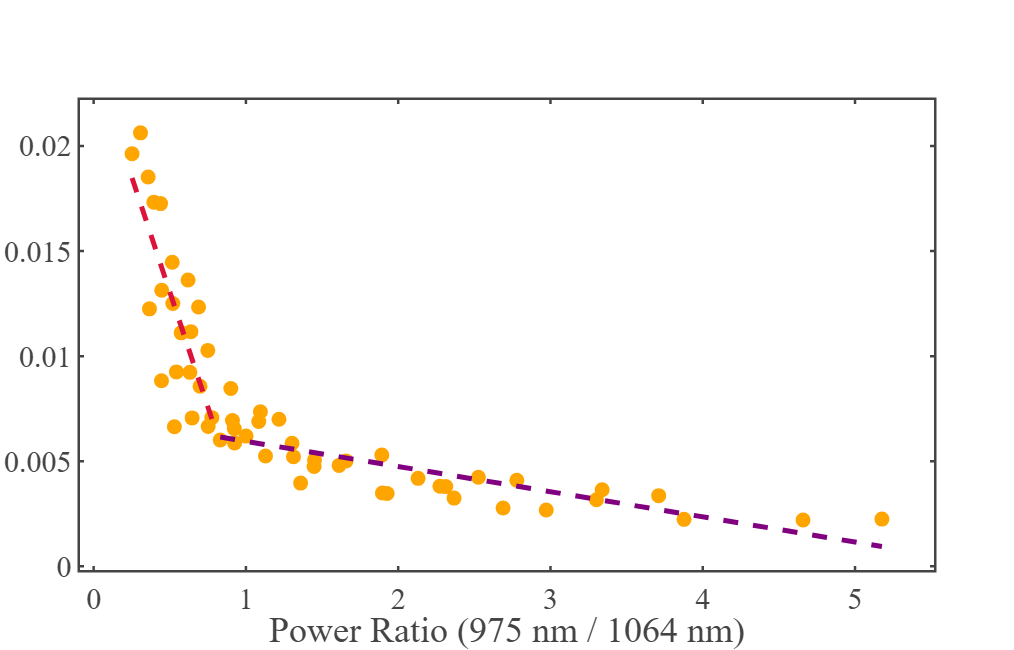

Linear Fit Parameters:
Region 1 (Power_Ratio <= 0.9): slope = -0.02189, intercept = 0.02400
Region 2 (Power_Ratio >= 0.8): slope = -0.00120, intercept = 0.00715
Power-law fit parameters: a = 0.00690, b = -0.73757


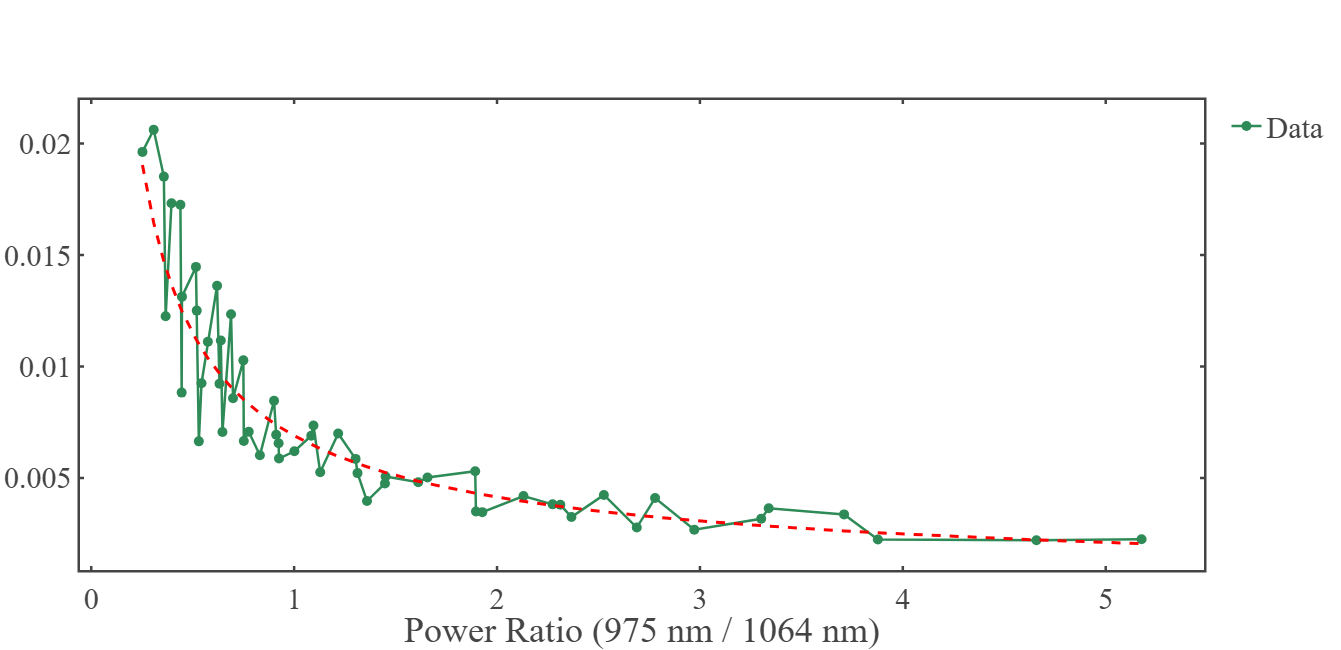

In [5]:
import numpy as np


# ============================================================
# --- Signal vs (975 nm / 1064 nm) Power Ratio ---
# ============================================================
df_ratio = df.copy()
df_ratio["Power_Ratio"] = df_ratio["P975_mW"] / df_ratio["P1064_mW"]

# Sort by ratio for clean plotting
df_ratio = df_ratio.sort_values("Power_Ratio")


# --- Define regions ---
region1_mask = df_ratio["Power_Ratio"] <= 0.8
region2_mask = df_ratio["Power_Ratio"] >= 0.8

# --- Region 1 fit ---
x1 = df_ratio.loc[region1_mask, "Power_Ratio"].values
y1 = df_ratio.loc[region1_mask, "Signal"].values
coeffs1 = np.polyfit(x1, y1, 1)  # linear fit y = m*x + c
y1_fit = np.polyval(coeffs1, x1)

# --- Region 2 fit ---
x2 = df_ratio.loc[region2_mask, "Power_Ratio"].values
y2 = df_ratio.loc[region2_mask, "Signal"].values
coeffs2 = np.polyfit(x2, y2, 1)
y2_fit = np.polyval(coeffs2, x2)

# --- Plot original data + two fits ---
fig3 = go.Figure()

# Original data
fig3.add_trace(go.Scatter(
    x=df_ratio["Power_Ratio"],
    y=df_ratio["Signal"],
    mode='markers',
    line=dict(width=2.5, color='orange'),
    marker=dict(size=15),
    showlegend=False
))

# Fit lines
fig3.add_trace(go.Scatter(
    x=x1, y=y1_fit,
    mode='lines',
    line=dict(color='crimson', width=5, dash='dash'),
    name='Fit Region 1',
    showlegend=False,
))
fig3.add_trace(go.Scatter(
    x=x2, y=y2_fit,
    mode='lines',
    line=dict(color='purple', width=5, dash='dash'),
    name='Fit Region 2',
    showlegend=False,
))

fig3.update_layout(
    template=fig_template,
    xaxis_title="Power Ratio (975 nm / 1064 nm)",
    # yaxis_type="log",
    width=800,
    height=650
)

output_path = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\ratio_powerVariation_high_withfits.png"
pio.write_image(fig3, output_path, format='png', scale=4)
print(f"✅ Figure saved as: {output_path}")

fig3.show()

print("Linear Fit Parameters:")
print(f"Region 1 (Power_Ratio <= 0.9): slope = {coeffs1[0]:.5f}, intercept = {coeffs1[1]:.5f}")
print(f"Region 2 (Power_Ratio >= 0.8): slope = {coeffs2[0]:.5f}, intercept = {coeffs2[1]:.5f}")


# --- Power-law fit ---
x_all = df_ratio["Power_Ratio"].values
y_all = df_ratio["Signal"].values

# Remove zeros or negatives to avoid log issues
mask = (x_all > 0) & (y_all > 0)
x_fit = x_all[mask]
y_fit = y_all[mask]

# Log-log fit: log(y) = log(a) + b*log(x)
log_x = np.log(x_fit)
log_y = np.log(y_fit)

b, log_a = np.polyfit(log_x, log_y, 1)
a = np.exp(log_a)

# Generate fitted curve
y_powerlaw = a * x_fit**b

print(f"Power-law fit parameters: a = {a:.5f}, b = {b:.5f}")


fig_power = go.Figure()

# Original data
fig_power.add_trace(go.Scatter(
    x=x_all,
    y=y_all,
    mode='markers+lines',
    line=dict(width=2.5, color='seagreen'),
    marker=dict(size=10),
    name='Data'
))

# Power-law fit
fig_power.add_trace(go.Scatter(
    x=x_fit,
    y=y_powerlaw,
    mode='lines',
    line=dict(color='red', width=3, dash='dash'),
    name=f'Power-law fit: y = {a:.2f}*x^{b:.2f}',
    showlegend=False,
))

fig_power.update_layout(
    template=fig_template,
    xaxis_title="Power Ratio (975 nm / 1064 nm)",
    # yaxis_type="log",
    width=800,
    height=650
)

fig_power.show()


### Heatmap for low 975nm powers  

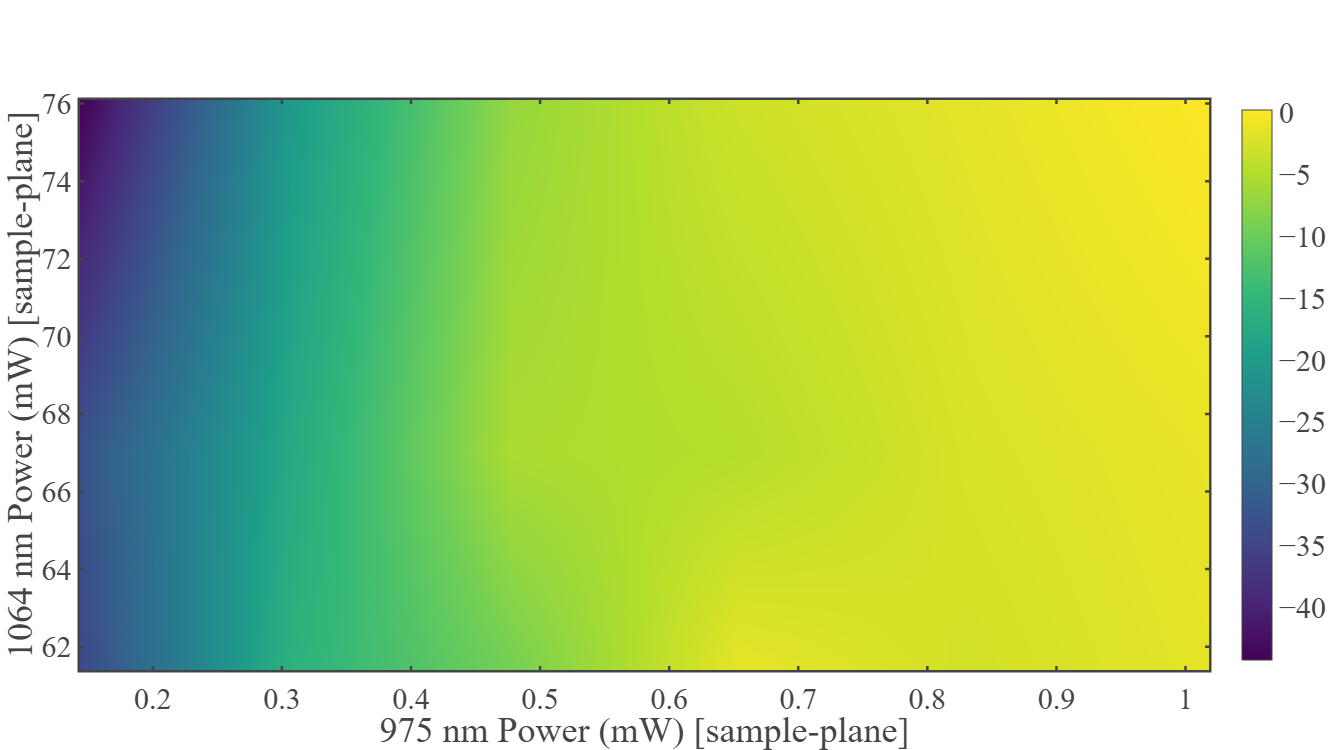

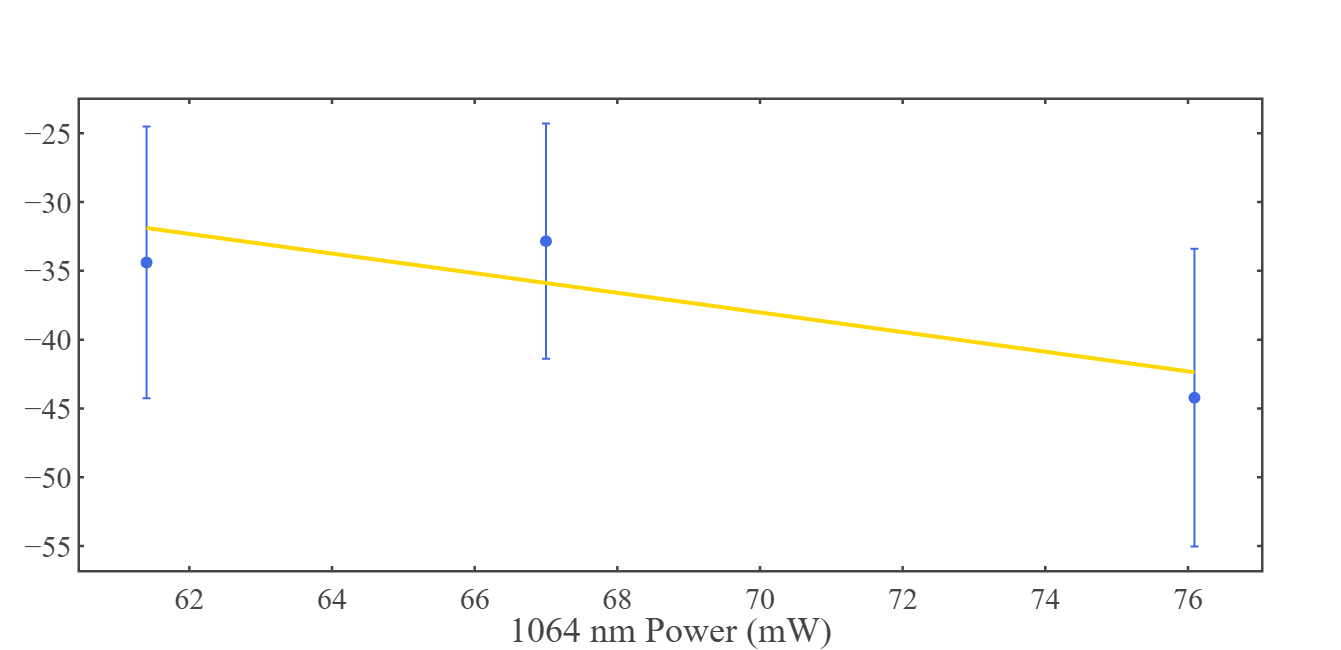

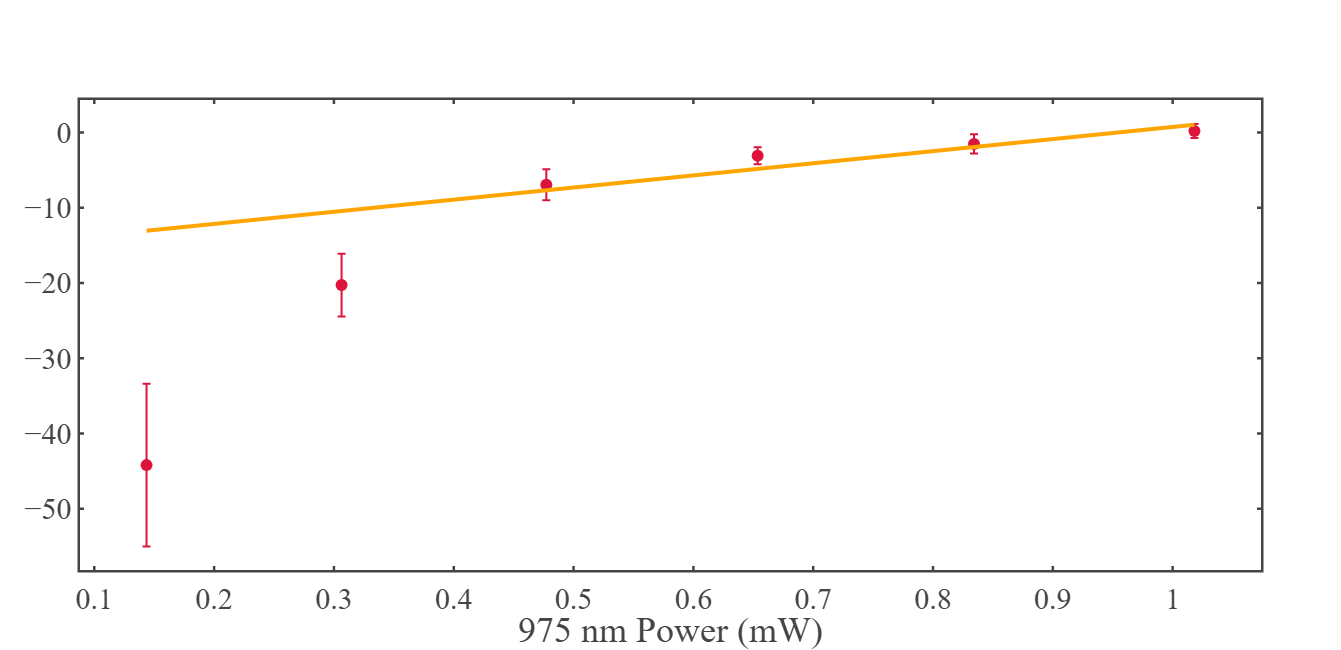

=== FIG1: Signal vs 1064 nm (lowest 975 = 0.14 mW) ===
 Slope (sensitivity) m = -7.138170e-01 %/mW ± 4.652836e-01
 Intercept c = 1.194911e+01 % ± 3.157201e+01

=== FIG2: Signal vs 975 nm (highest 1064 = 76.09 mW) ===
 Slope (sensitivity) m = 1.613411e+01 %/mW ± 6.184567e+00
 Intercept c = -1.540039e+01 % ± 5.190803e+00

=== Data Statistics ===
Signal range: -44.22% to 0.19%
1064 nm power range: 61.40 mW to 76.09 mW
975 nm power range: 0.14 mW to 1.02 mW
=== Normalized sensitivities ===
Normalized sensitivity (1064) = 2.173561e-02 per mW
Normalized sensitivity (975)  = 8.689179e+01 per mW
Fractional signal change over full 1064 nm range: 0.319
Fractional signal change over full 975 nm range: 75.994


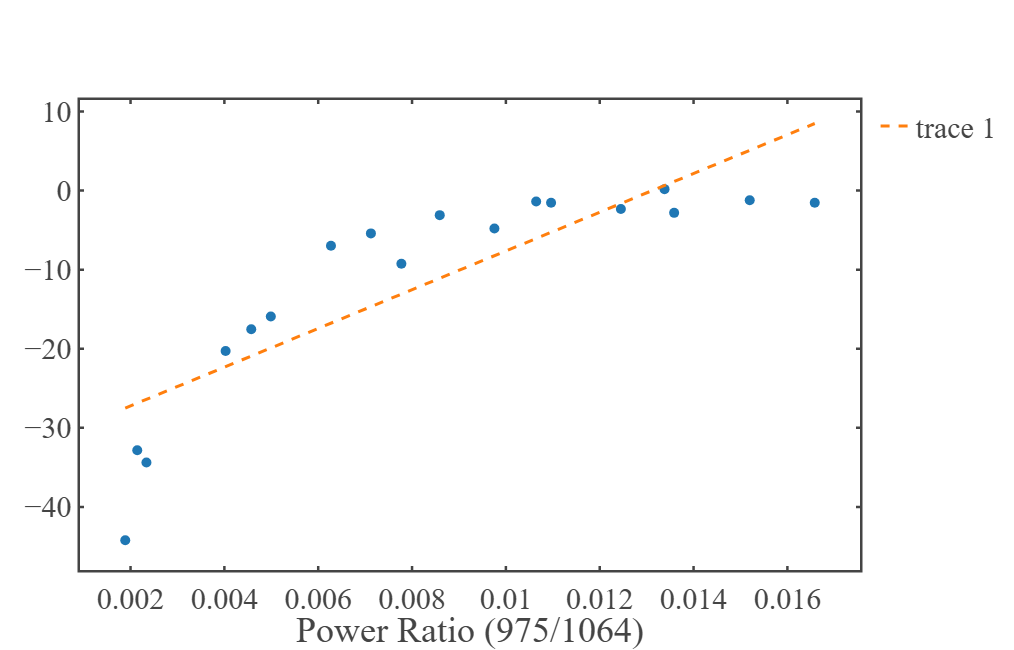

Not enough positive points for power-law fit of Signal vs Ratio.

Sample entries from processed low-power dataframe:
                                                                                                                                      file  P1064_raw  P975_raw_mW  P1064_mW  P975_mW     Signal
C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\7th Oct NaBiF4\face on\good datas\1064nm_3.65mA\975nm_1mW.txt       3.65          1.0      61.4 0.143606 -34.385688
C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\7th Oct NaBiF4\face on\good datas\1064nm_3.65mA\975nm_2mW.txt       3.65          2.0      61.4 0.306373 -15.922700
C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\7th Oct NaBiF4\face on\good datas\1064nm_3.65mA\975nm_3mW.txt       3.65          3.0      61.4 0.477253  -9.238728
C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\7th Oct NaBiF4\face on\good datas\

In [46]:
import numpy as np
import pandas as pd
import os
import re
from scipy.interpolate import interp1d
import plotly.graph_objects as go
import plotly.io as pio

# ============================================================
# --- Original calibration tables (kept for consistency) ---
# ============================================================
calib_975_raw = {10:1.79,30:5.4,50:10,70:16.87,90:22,110:25.4,130:29.72,150:31.21,170:36.48,190:43,210:52.5,230:53.62,250:60.57}
calib_1064 = {1.75:4.6,2:7.6,2.25:10.25,2.5:14.3,2.75:21,3:36.65,3.25:43.6,3.5:53,3.75:67,3.86:77}

# ============================================================
# --- Power-law fit for 975 nm calibration (Option D) ---
# Fit log(y) = log(a) + b*log(x) --> y = a * x^b
# ============================================================
# Convert dict to arrays (sorted by raw power)
x_cal = np.array(sorted(calib_975_raw.keys()), dtype=float)
y_cal = np.array([calib_975_raw[k] for k in x_cal], dtype=float)

# Avoid zeros/negatives
mask_pos = (x_cal > 0) & (y_cal > 0)
if mask_pos.sum() < 2:
    raise RuntimeError("Not enough positive calibration points for power-law fit.")

log_x = np.log(x_cal[mask_pos])
log_y = np.log(y_cal[mask_pos])
b_975, log_a_975 = np.polyfit(log_x, log_y, 1)
a_975 = np.exp(log_a_975)

def calib_975_powerlaw(raw_mw):
    """Convert raw 975 nm dial power (mW) to sample-plane power (mW) using power-law fit."""
    raw_mw = np.array(raw_mw, dtype=float)
    return a_975 * (raw_mw ** b_975)

# Keep 1064 interpolation as before (keys are numerical current values -> sample mW)
interp_1064 = interp1d(list(calib_1064.keys()), list(calib_1064.values()), fill_value="extrapolate")

# ============================================================
# --- Figure Template ---
# ============================================================
fig_template = go.layout.Template()
fig_template.layout = {
    'template': 'simple_white+presentation',
    'autosize': False,
    'width': 800,
    'height': 600,
    'xaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False,'zerolinecolor':'white'},
    'yaxis': {'ticks':'inside','mirror':'ticks','linewidth':2.5,'tickwidth':2.5,'ticklen':4,'showline':True,'showgrid':False,'zerolinecolor':'white'},
    'font': {'family':'mathjax','size':30}
}

# ============================================================
# --- Parameters & paths (LOW 975-power dataset) ---
# ============================================================
base_path_low = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\datas\7th Oct NaBiF4\face on\good datas"
output_fig_folder = r"C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper"
os.makedirs(output_fig_folder, exist_ok=True)

# Time windows (ms) — same as your previous groups
groups = [(21,24),(46,49),(71,74),(96,99)]

# Filename patterns
# Files may be under folders like "1064nm_3.85mA" and file names like "975nm_1mW.txt"
# We'll extract 1064 from folder and 975 from filename, but also accept other naming formats.
file_pattern_975 = re.compile(r"975nm[_-]?(\d*\.?\d+)mW", re.IGNORECASE)
folder_pattern_1064 = re.compile(r"1064nm[_-]?(\d*\.?\d+)(mA|mW)?", re.IGNORECASE)

# ============================================================
# --- Helper Functions ---
# ============================================================
def extract_mean_std(file_path):
    """Read a two-column text file (time, intensity). Time is in ns in your files -> convert to ms."""
    arr = np.loadtxt(file_path, skiprows=1)
    if arr.ndim == 1 and arr.size >= 2:
        arr = arr.reshape(1, -1)
    time_ms = arr[:,0] / 1e9  # ns -> seconds -> *1000 => ms, but dividing by 1e9 gives seconds, then ms -> hmm...
    # NOTE: earlier code used time_ms = arr[:,0] / 1e9 (so t in seconds??) and compared to groups in ms.
    # To be consistent with your original code, keep the same conversion (you used /1e9 and compared to ms windows),
    # so we will keep it identical. If that was an oversight, change as needed.
    intensity = arr[:,1]
    regions=[]
    for (t1,t2) in groups:
        mask = (time_ms >= t1) & (time_ms <= t2)
        vals = intensity[mask]
        if len(vals)==0:
            vals = np.array([np.nan])
        regions.append(vals)
    g1 = np.concatenate([regions[0], regions[2]])
    g2 = np.concatenate([regions[1], regions[3]])
    mean1,std1 = np.nanmean(g1), np.nanstd(g1)
    mean2,std2 = np.nanmean(g2), np.nanstd(g2)
    if np.isfinite(mean1) and mean1>0:
        signal = 100.0*(mean1-mean2)/mean1
        ds_dm1 = 100.0*(mean2/(mean1**2))
        ds_dm2 = -100.0/mean1
        signal_std = np.sqrt((ds_dm1*std1)**2 + (ds_dm2*std2)**2)
    else:
        signal, signal_std = np.nan, np.nan
    return signal, signal_std

def linear_fit_with_uncertainty(x, y, weights=None):
    mask = np.isfinite(x) & np.isfinite(y)
    x, y = np.array(x)[mask], np.array(y)[mask]
    if len(x) < 2:
        return np.nan, np.nan, np.nan, np.nan
    if weights is not None:
        w = np.array(weights)[mask]
        # numpy.polyfit with w expects 1/sigma or similar; keep semantics from previous code
        p, cov = np.polyfit(x, y, 1, w=w, cov=True)
    else:
        p, cov = np.polyfit(x, y, 1, cov=True)
    m, c = p[0], p[1]
    sm = np.sqrt(cov[0,0]) if cov is not None else np.nan
    sc = np.sqrt(cov[1,1]) if cov is not None else np.nan
    return m, c, sm, sc

# ============================================================
# --- Loop through folders & files (low-power set) ---
# ============================================================
results=[]
for folder in os.listdir(base_path_low):
    folder_path = os.path.join(base_path_low, folder)
    if not os.path.isdir(folder_path):
        continue

    # Try extracting 1064 value from folder name
    m_1064 = None
    m = folder_pattern_1064.search(folder)
    if m:
        try:
            m_1064 = float(m.group(1))
        except:
            m_1064 = None

    # iterate files inside
    for file in os.listdir(folder_path):
        if not file.lower().endswith(".txt"):
            continue

        # Try to get 975 from filename
        m2 = file_pattern_975.search(file)
        if not m2:
            # If filename doesn't contain 975, skip
            continue
        p_975_raw = float(m2.group(1))  # raw dial mW for 975 laser

        # If folder didn't give 1064 number, try filename match (older naming convention)
        if m_1064 is None:
            match_folder_like = re.search(r"1064nm[_-]?(\d*\.?\d+)(mA|mW)?", file, re.IGNORECASE)
            if match_folder_like:
                m_1064 = float(match_folder_like.group(1))

        if m_1064 is None:
            # cannot find 1064 value; skip file
            continue

        # Convert raw values to sample-plane powers
        try:
            p_1064_sample = float(interp_1064(m_1064))
        except Exception:
            p_1064_sample = np.nan

        # Use power-law conversion for 975
        try:
            p_975_sample = float(calib_975_powerlaw(p_975_raw))
        except Exception:
            p_975_sample = np.nan

        file_path = os.path.join(folder_path, file)
        signal, signal_std = extract_mean_std(file_path)
        results.append({"P1064_mW":p_1064_sample,"P975_mW":p_975_sample,"Signal":signal,"Signal_std":signal_std,
                        "P975_raw_mW":p_975_raw,"P1064_raw":m_1064,"file":file_path})

df = pd.DataFrame(results)
# Drop rows where signal or power is NaN
df = df.dropna(subset=["Signal","P975_mW","P1064_mW"])

if df.empty:
    raise RuntimeError("No valid low-power data found. Check base_path_low and file/folder naming conventions.")

# ============================================================
# --- Contour / Heatmap for low-power set ---
# ============================================================
pivot_signal = df.pivot_table(index="P1064_mW", columns="P975_mW", values="Signal", aggfunc="mean").sort_index(ascending=True)
fig = go.Figure()
fig.add_trace(go.Contour(
    x=pivot_signal.columns,
    y=pivot_signal.index,
    z=pivot_signal.values,
    contours_coloring='heatmap',
    connectgaps=False,
    line_smoothing=1,
    coloraxis='coloraxis'
))
fig.update_layout(
    template=fig_template,
    xaxis_title="975 nm Power (mW) [sample-plane]",
    yaxis_title="1064 nm Power (mW) [sample-plane]",
    width=900, height=750,
    coloraxis={'colorscale':'Viridis','cmin':np.nanmin(pivot_signal.values),'cmax':np.nanmax(pivot_signal.values),'showscale':True}
)
fig.update_traces(line_width=0)
out_heatmap = os.path.join(output_fig_folder, "heatmap_lowP_975_powerlaw_calib.png")
# pio.write_image(fig, out_heatmap, format='png', scale=4)
# print(f"Saved heatmap: {out_heatmap}")
fig.show()

# ============================================================
# --- FIG1: Signal vs 1064 nm (lowest 975 nm power) ---
# ============================================================
lowest_975 = df["P975_mW"].min()
subset_low_975 = df[df["P975_mW"]==lowest_975].sort_values("P1064_mW")
x1, y1, s1 = subset_low_975["P1064_mW"].values, subset_low_975["Signal"].values, subset_low_975["Signal_std"].values

weights1 = (1/s1) if (len(s1)>0 and np.all(s1>0)) else None
m1, c1, sm1, sc1 = linear_fit_with_uncertainty(x1, y1, weights=weights1)

fig1 = go.Figure()
fig1.add_trace(go.Scatter(
    x=x1, y=y1,
    error_y=dict(type='data', array=s1, visible=True),
    mode='markers',
    marker=dict(size=12, color='royalblue'),
    name=f"975 nm = {lowest_975:.2f} mW",
    showlegend =False,
))
x1_fit = np.linspace(np.nanmin(x1), np.nanmax(x1), 200) if len(x1)>1 else x1
y1_fit = m1*x1_fit + c1
fig1.add_trace(go.Scatter(
    x=x1_fit, y=y1_fit,
    mode='lines',
    line=dict(color='gold', width=4),
    name=f"Linear fit",
    showlegend =False,
))
fig1.update_layout(template=fig_template,
                   xaxis_title="1064 nm Power (mW)",
                   width=800, height=650)
out_fig1 = os.path.join(output_fig_folder, "1064_vs_signal_low975.png")
# pio.write_image(fig1, out_fig1, format='png', scale=4)
# print(f"Saved: {out_fig1}")
fig1.show()

# ============================================================
# --- FIG2: Signal vs 975 nm (highest 1064 nm power) ---
# ============================================================
highest_1064 = df["P1064_mW"].max()
subset_high_1064 = df[df["P1064_mW"]==highest_1064].sort_values("P975_mW")
x2, y2, s2 = subset_high_1064["P975_mW"].values, subset_high_1064["Signal"].values, subset_high_1064["Signal_std"].values

weights2 = (1/s2) if (len(s2)>0 and np.all(s2>0)) else None
m2, c2, sm2, sc2 = linear_fit_with_uncertainty(x2, y2, weights=weights2)

fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=x2, y=y2,
    error_y=dict(type='data', array=s2, visible=True),
    mode='markers',
    marker=dict(size=12, color='crimson'),
    name=f"1064 nm = {highest_1064:.2f} mW",
    showlegend =False,
))
x2_fit = np.linspace(np.nanmin(x2), np.nanmax(x2), 200) if len(x2)>1 else x2
y2_fit = m2*x2_fit + c2
fig2.add_trace(go.Scatter(
    x=x2_fit, y=y2_fit,
    mode='lines',
    line=dict(color='orange', width=4),
    name=f"Linear fit",
    showlegend =False,
))
fig2.update_layout(template=fig_template,
                   xaxis_title="975 nm Power (mW)",
                   width=800, height=650)
out_fig2 = os.path.join(output_fig_folder, "975_vs_signal_low975.png")
# pio.write_image(fig2, out_fig2, format='png', scale=4)
# print(f"Saved: {out_fig2}")
fig2.show()

# ================================
# --- Fitted Parameters & Sensitivities ---
# ================================
print("=== FIG1: Signal vs 1064 nm (lowest 975 = {:.2f} mW) ===".format(lowest_975))
print(f" Slope (sensitivity) m = {m1:.6e} %/mW ± {sm1:.6e}")
print(f" Intercept c = {c1:.6e} % ± {sc1:.6e}\n")

print("=== FIG2: Signal vs 975 nm (highest 1064 = {:.2f} mW) ===".format(highest_1064))
print(f" Slope (sensitivity) m = {m2:.6e} %/mW ± {sm2:.6e}")
print(f" Intercept c = {c2:.6e} % ± {sc2:.6e}\n")

print("=== Data Statistics ===")
print(f"Signal range: {np.nanmin(df['Signal']):.2f}% to {np.nanmax(df['Signal']):.2f}%")
print(f"1064 nm power range: {np.nanmin(df['P1064_mW']):.2f} mW to {np.nanmax(df['P1064_mW']):.2f} mW")
print(f"975 nm power range: {np.nanmin(df['P975_mW']):.2f} mW to {np.nanmax(df['P975_mW']):.2f} mW")

# ================================
# --- Sensitivities & Normalized Sensitivities ---
# ================================
max_signal_1064 = np.nanmax(subset_low_975["Signal"]) if len(subset_low_975)>0 else np.nan
max_signal_975 = np.nanmax(subset_high_1064["Signal"]) if len(subset_high_1064)>0 else np.nan

sensitivity_1064 = m1
sensitivity_975  = m2

normalized_sens_1064 = sensitivity_1064 / max_signal_1064 if np.isfinite(max_signal_1064) and max_signal_1064!=0 else np.nan
normalized_sens_975  = sensitivity_975 / max_signal_975 if np.isfinite(max_signal_975) and max_signal_975!=0 else np.nan

print("=== Normalized sensitivities ===")
print(f"Normalized sensitivity (1064) = {normalized_sens_1064:.6e} per mW")
print(f"Normalized sensitivity (975)  = {normalized_sens_975:.6e} per mW")

# Fractional change across full ranges
frac_change_1064 = sensitivity_1064 * (np.nanmax(subset_low_975["P1064_mW"]) - np.nanmin(subset_low_975["P1064_mW"])) / max_signal_1064 if np.isfinite(max_signal_1064) and max_signal_1064!=0 else np.nan
frac_change_975  = sensitivity_975  * (np.nanmax(subset_high_1064["P975_mW"]) - np.nanmin(subset_high_1064["P975_mW"])) / max_signal_975 if np.isfinite(max_signal_975) and max_signal_975!=0 else np.nan

print(f"Fractional signal change over full 1064 nm range: {frac_change_1064:.3f}")
print(f"Fractional signal change over full 975 nm range: {frac_change_975:.3f}")

# ============================================================
# --- Power-ratio analysis & fits (same as before) ---
# ============================================================
df_ratio = df.copy()
df_ratio["Power_Ratio"] = df_ratio["P975_mW"] / df_ratio["P1064_mW"]
df_ratio = df_ratio.sort_values("Power_Ratio")

region1_mask = df_ratio["Power_Ratio"] <= 0.8
region2_mask = df_ratio["Power_Ratio"] >= 0.8

# Region 1
x1r = df_ratio.loc[region1_mask, "Power_Ratio"].values
y1r = df_ratio.loc[region1_mask, "Signal"].values
coeffs1 = np.polyfit(x1r, y1r, 1) if len(x1r)>1 else (np.nan, np.nan)
y1_fit = np.polyval(coeffs1, x1r) if len(x1r)>0 else np.array([])

# Region 2
x2r = df_ratio.loc[region2_mask, "Power_Ratio"].values
y2r = df_ratio.loc[region2_mask, "Signal"].values
coeffs2 = np.polyfit(x2r, y2r, 1) if len(x2r)>1 else (np.nan, np.nan)
y2_fit = np.polyval(coeffs2, x2r) if len(x2r)>0 else np.array([])

fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=df_ratio["Power_Ratio"],
    y=df_ratio["Signal"],
    mode='markers',
    marker=dict(size=10),
    showlegend=False
))
if len(x1r)>0:
    fig3.add_trace(go.Scatter(x=x1r, y=y1_fit, mode='lines', line=dict(width=3, dash='dash')))
if len(x2r)>0:
    fig3.add_trace(go.Scatter(x=x2r, y=y2_fit, mode='lines', line=dict(width=3, dash='dash')))

fig3.update_layout(template=fig_template, xaxis_title="Power Ratio (975/1064)", width=800, height=650)
out_fig3 = os.path.join(output_fig_folder, "ratio_low975_two_region_fits.png")
# pio.write_image(fig3, out_fig3, format='png', scale=4)
# print(f"Saved: {out_fig3}")
fig3.show()

# Power-law fit (signal vs ratio) as before
x_all = df_ratio["Power_Ratio"].values
y_all = df_ratio["Signal"].values
mask = (x_all > 0) & (y_all > 0)
if mask.sum() >= 2:
    log_xar = np.log(x_all[mask])
    log_yar = np.log(y_all[mask])
    b_r, log_a_r = np.polyfit(log_xar, log_yar, 1)
    a_r = np.exp(log_a_r)
    y_powerlaw = a_r * (x_all[mask] ** b_r)
    print(f"Power-law fit parameters (Signal vs Ratio): a = {a_r:.5f}, b = {b_r:.5f}")
    fig_power = go.Figure()
    fig_power.add_trace(go.Scatter(x=x_all, y=y_all, mode='markers+lines', marker=dict(size=8)))
    fig_power.add_trace(go.Scatter(x=x_all[mask], y=y_powerlaw, mode='lines', line=dict(width=3, dash='dash')))
    fig_power.update_layout(template=fig_template, xaxis_title="Power Ratio (975/1064)", width=800, height=650)
    out_power = os.path.join(output_fig_folder, "powerlaw_signal_vs_ratio_low975.png")
    pio.write_image(fig_power, out_power, format='png', scale=4)
    print(f"Saved: {out_power}")
    fig_power.show()
else:
    print("Not enough positive points for power-law fit of Signal vs Ratio.")

# ============================================================
# --- Print summary of where data came from (few rows) ---
# ============================================================
print("\nSample entries from processed low-power dataframe:")
print(df[["file","P1064_raw","P975_raw_mW","P1064_mW","P975_mW","Signal"]].head(10).to_string(index=False))

# ============================================================
# --- End ---
# ============================================================


✅ Figure saved: C:\Users\Atanu\OneDrive\Desktop\research_work\paper\NaBiF4_PL_analysis\figures in paper\ratio_powerVariation_low_withfits.png


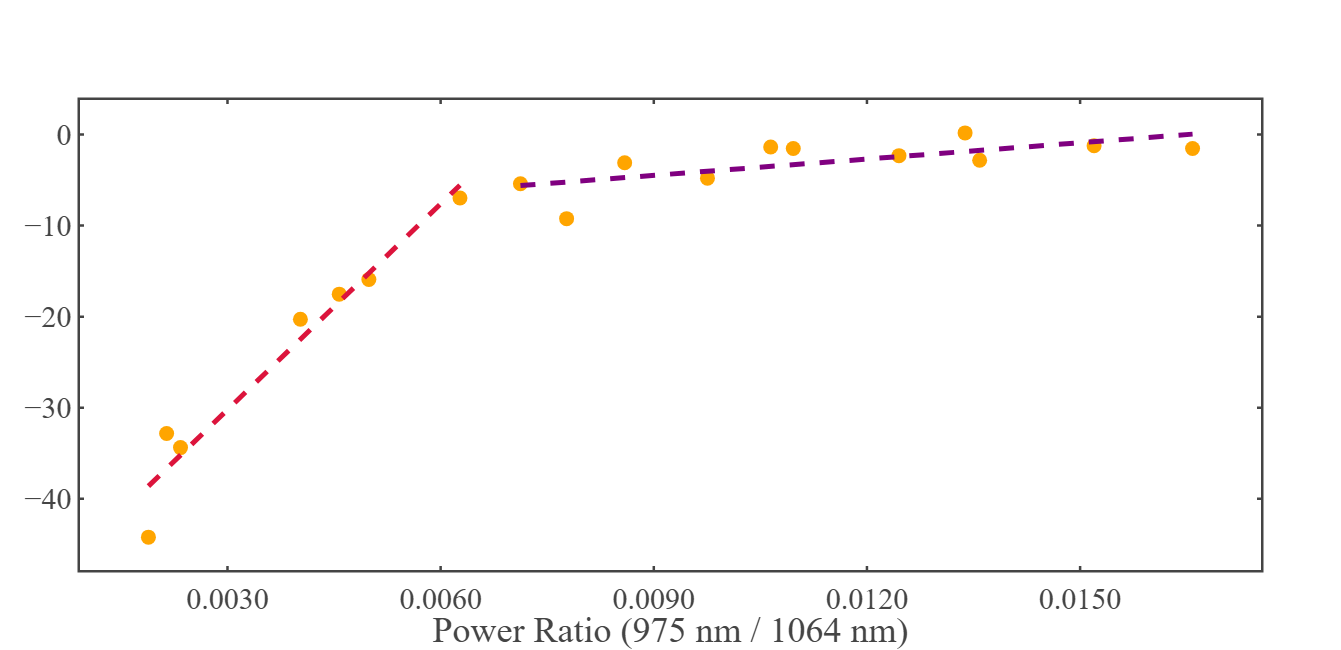

Linear Fit Parameters:
Region 1 (Power_Ratio <= 0.0071): slope = 7538.12831, intercept = -52.84010
Region 2 (Power_Ratio > 0.0071): slope = 597.31689, intercept = -9.85750


In [86]:
import numpy as np
import plotly.graph_objects as go
import os
import plotly.io as pio

# ============================================================
# --- Prepare Power Ratio & Signal ---
# ============================================================
df_ratio = df.copy()  # assuming df is already defined from previous processing
df_ratio["Power_Ratio"] = df_ratio["P975_mW"] / df_ratio["P1064_mW"]
df_ratio = df_ratio.sort_values("Power_Ratio")

# Threshold for two-region fit
threshold = 0.0071

# --- Define regions ---
region1_mask = df_ratio["Power_Ratio"] <= threshold
region2_mask = df_ratio["Power_Ratio"] > threshold

# --- Linear fits ---
x1 = df_ratio.loc[region1_mask, "Power_Ratio"].values
y1 = df_ratio.loc[region1_mask, "Signal"].values
coeffs1 = np.polyfit(x1, y1, 1)
y1_fit = np.polyval(coeffs1, x1)

x2 = df_ratio.loc[region2_mask, "Power_Ratio"].values
y2 = df_ratio.loc[region2_mask, "Signal"].values
coeffs2 = np.polyfit(x2, y2, 1)
y2_fit = np.polyval(coeffs2, x2)

# ============================================================
# --- Choose x-ticks to display (linear intervals) ---
# ============================================================
# xticks_to_show = np.linspace(0.002, 0.017, 4)  # 8 evenly spaced ticks
xticks_to_show =  [0.003, 0.006, 0.009, 0.012, 0.015]

# ============================================================
# --- Plot original data + two linear fits ---
# ============================================================
fig3 = go.Figure()

# Original data
fig3.add_trace(go.Scatter(
    x=df_ratio["Power_Ratio"],
    y=df_ratio["Signal"],
    mode='markers',
    line=dict(width=2.5, color='orange'),
    marker=dict(size=15),
    showlegend=False
))

# Fit lines
fig3.add_trace(go.Scatter(
    x=x1, y=y1_fit,
    mode='lines',
    line=dict(color='crimson', width=5, dash='dash'),
    showlegend=False,
))
fig3.add_trace(go.Scatter(
    x=x2, y=y2_fit,
    mode='lines',
    line=dict(color='purple', width=5, dash='dash'),
    showlegend=False,
))



fig3.update_layout(
    template=fig_template,
    xaxis_title="Power Ratio (975 nm / 1064 nm)",
    # yaxis_title="Signal (%)",
    xaxis=dict(
        tickvals=xticks_to_show,
        ticktext=[f"{v:.4f}" for v in xticks_to_show]
    ),
    width=800,
    height=650
)

# Save figure
output_path = os.path.join(output_fig_folder, "ratio_powerVariation_low_withfits.png")
pio.write_image(fig3, output_path, format='png', scale=4)
print(f"✅ Figure saved: {output_path}")

fig3.show()

# ============================================================
# --- Print slopes and intercepts ---
# ============================================================
print("Linear Fit Parameters:")
print(f"Region 1 (Power_Ratio <= {threshold}): slope = {coeffs1[0]:.5f}, intercept = {coeffs1[1]:.5f}")
print(f"Region 2 (Power_Ratio > {threshold}): slope = {coeffs2[0]:.5f}, intercept = {coeffs2[1]:.5f}")


In [78]:
np.linspace(0.001, 0.018, 4)

array([0.001     , 0.00666667, 0.01233333, 0.018     ])

#### extrapolation to lower power of 975nm 

Power-law fit: sample = 0.1436 * raw^1.0932

Extrapolated 975 nm low-power values (1–9 mW):
 1 mW  →  0.1436 mW
 2 mW  →  0.3064 mW
 3 mW  →  0.4773 mW
 4 mW  →  0.6536 mW
 5 mW  →  0.8342 mW
 6 mW  →  1.0182 mW
 7 mW  →  1.2051 mW
 8 mW  →  1.3945 mW
 9 mW  →  1.5861 mW


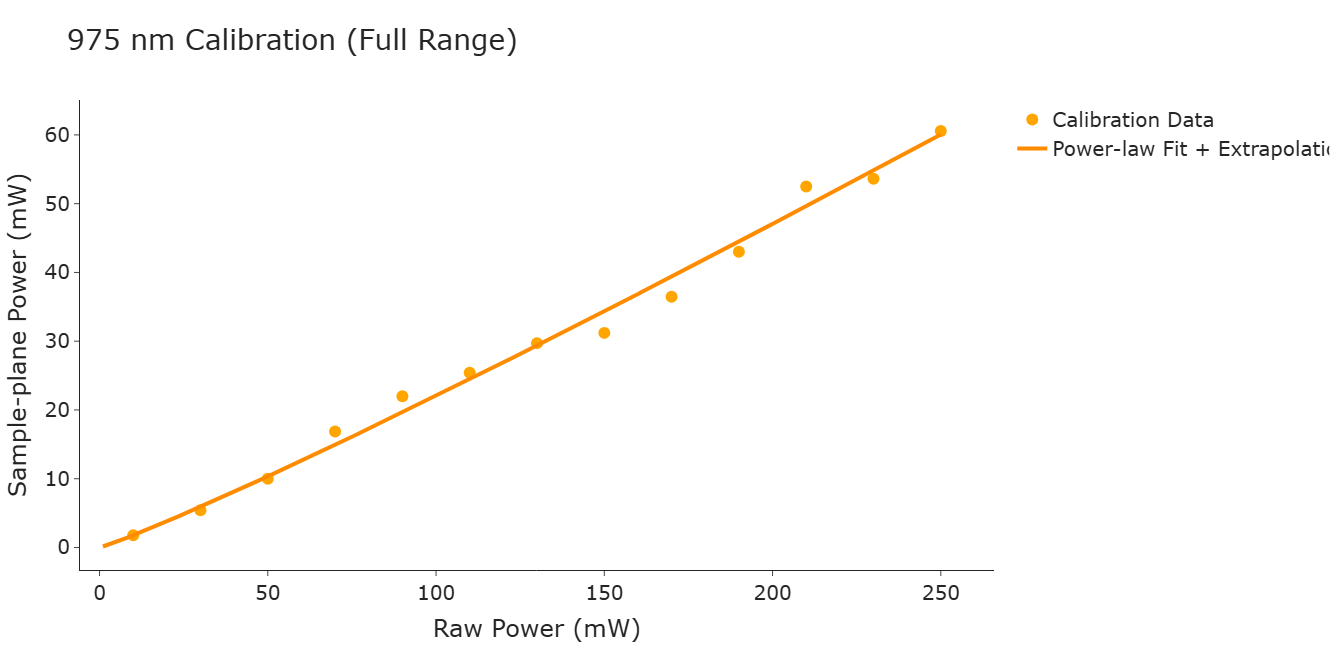

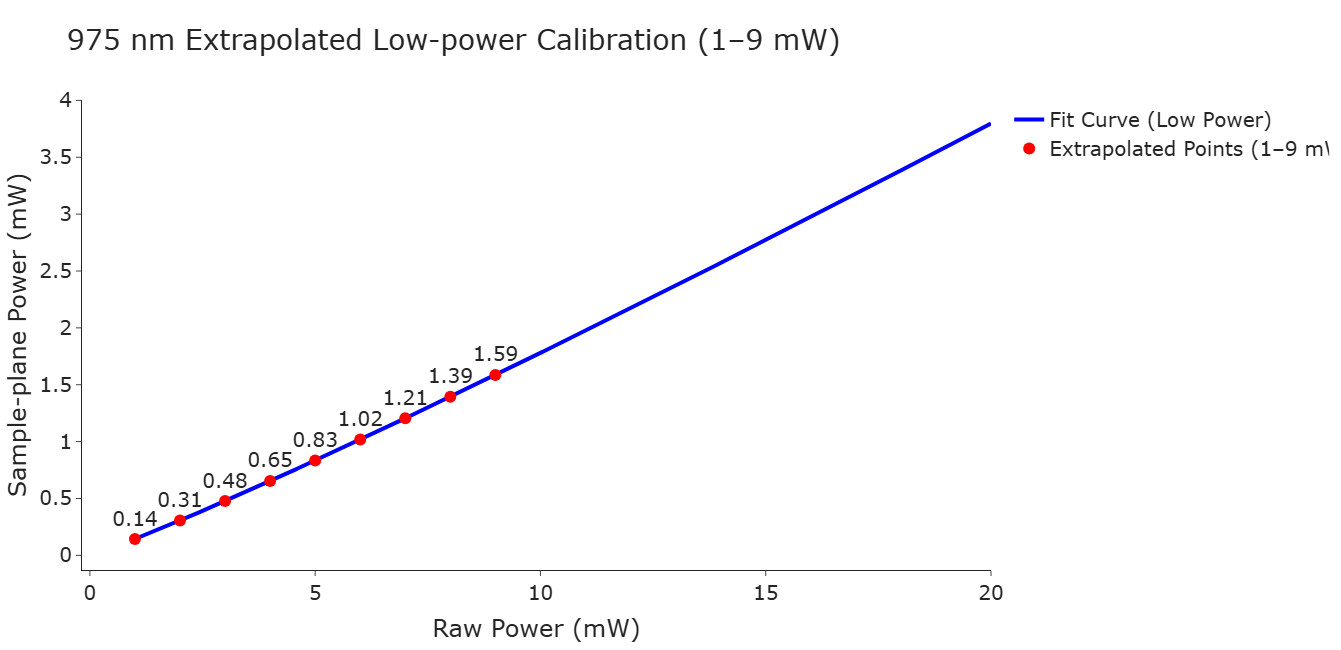

In [13]:
import numpy as np
import plotly.graph_objects as go

# ============================================================
# 975 nm calibration data (raw → sample-plane mW)
# ============================================================
raw_power = np.array([10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210, 230, 250], dtype=float)
sample_power = np.array([1.79, 5.4, 10, 16.87, 22, 25.4, 29.72, 31.21, 36.48, 43, 52.5, 53.62, 60.57], dtype=float)

# ============================================================
# Power-law fit: sample = a * raw^b
# ============================================================
log_x = np.log(raw_power)
log_y = np.log(sample_power)
b, log_a = np.polyfit(log_x, log_y, 1)
a = np.exp(log_a)

print(f"Power-law fit: sample = {a:.4f} * raw^{b:.4f}")

# Smooth curve from 1→250 mW
raw_fit = np.linspace(1, 250, 500)
sample_fit = a * raw_fit**b

# ------------------------------------------------------------
# Extrapolated low-power values (1–9 mW)
# ------------------------------------------------------------
raw_low = np.arange(1, 10, 1)
sample_low = a * raw_low**b

print("\nExtrapolated 975 nm low-power values (1–9 mW):")
for rp, sp in zip(raw_low, sample_low):
    print(f"{rp:2d} mW  →  {sp:.4f} mW")


# ============================================================
# PLOT 1: Full calibration + fitted curve
# ============================================================
fig1 = go.Figure()

fig1.add_trace(go.Scatter(
    x=raw_power,
    y=sample_power,
    mode='markers',
    marker=dict(size=12, color='orange'),
    name="Calibration Data"
))

fig1.add_trace(go.Scatter(
    x=raw_fit,
    y=sample_fit,
    mode='lines',
    line=dict(width=4, color='darkorange'),
    name="Power-law Fit + Extrapolation"
))

fig1.update_layout(
    title="975 nm Calibration (Full Range)",
    xaxis_title="Raw Power (mW)",
    yaxis_title="Sample-plane Power (mW)",
    template="simple_white",
    width=900,
    height=650,
    font=dict(size=20)
)

fig1.show()


# ============================================================
# PLOT 2: Only the extrapolated low-power region
# ============================================================
fig2 = go.Figure()

# Smooth fit (1→20 mW for visualization)
raw_low_fit = np.linspace(1, 20, 300)
sample_low_fit = a * raw_low_fit**b

fig2.add_trace(go.Scatter(
    x=raw_low_fit,
    y=sample_low_fit,
    mode='lines',
    line=dict(width=4, color='blue'),
    name="Fit Curve (Low Power)"
))

fig2.add_trace(go.Scatter(
    x=raw_low,
    y=sample_low,
    mode='markers+text',
    marker=dict(size=12, color='red'),
    text=[f"{val:.2f}" for val in sample_low],
    textposition="top center",
    name="Extrapolated Points (1–9 mW)"
))

fig2.update_layout(
    title="975 nm Extrapolated Low-power Calibration (1–9 mW)",
    xaxis_title="Raw Power (mW)",
    yaxis_title="Sample-plane Power (mW)",
    template="simple_white",
    width=900,
    height=650,
    font=dict(size=20)
)

fig2.show()
